### trying to add augmentation to a base dataloader

In [1]:
%load_ext autoreload

In [30]:
%autoreload

In [31]:
from twaibrain.braintorch.data import SingleVisitDataset_V1, MultiIndependentVisitDataset_V1, SitkImageDataset_V1, RandomSubjectVisitDataset_V1, SingleVisitDatasetInRam_V1, MultiIndependentVisitDatasetInRam_V1, RandomSubjectVisitDatasetInRam_V1
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [32]:
from twaibrain.braintorch.augmentation.nnunet_augmentations import get_nnunet_transforms, get_simple_transforms, get_val_transforms

In [33]:
lbc_val = SingleVisitDatasetInRam_V1(
        dataset_folder="/home/s2208943/preprocessed_data/",#"/workspace/writeable/datasets/preprocessed_data",
        config_name="policyproblem_train",
        ds_name="LBC",
        visit_key="ses",
        ds_experiment_name='',
        split='val',
        resample=True,
        out_spacing=[1,1,2],
        fit_to_mask=True,
        mask_pad=0,
        fit_to_shape=True,
        output_shape=[80,192,160],
        key_renames = {'wave2-WMH':'lbcWMH', 'wave3-WMH':'lbcWMH', 'wave3-WMH':'lbcWMH', 'wave4-WMH':'lbcWMH', 'wave5-WMH':'lbcWMH'}
                           )

100%|███████████████████████████████████████████████████████████████| 69/69 [00:10<00:00,  6.58it/s]


In [5]:
len(lbc_val)

69

In [24]:
%autoreload

In [25]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, base_dataset, transforms):
        super().__init__()
        self.base_dataset = base_dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        data = self.base_dataset[idx]

        data = self.transforms(data)

        return data

In [39]:
from torch import float32, long, cat
import torch.nn.functional as F
from twaibrain.braintorch.augmentation.nnunet_augmentations import *

class MonaiPairedPadToShape2d_V2:
    def __init__(self, target_shape, padding_mode="constant", padding_value=0, keys=['image', 'mask', 'label']):
        self.target_shape = target_shape
        self.padding_mode = padding_mode
        self.padding_value = padding_value
        self.keys = keys

    def __call__(self, data):
        for key in self.keys():
            img = data[key]
        
            _, h, w = img.shape
            target_h, target_w = self.target_shape
    
            pad_h = max(0, target_h - h)
            pad_w = max(0, target_w - w)
    
            padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
            img = F.pad(img, padding, mode=self.padding_mode, value=self.padding_value)
    
            data[key] = img
        
        return data

class MonaiCropAndPadToShape3d_V2:
    def __init__(self, target_shape, padding_mode="constant", padding_value=0, keys=['image', 'mask', 'label']):
        self.target_shape = target_shape
        self.padding_mode = padding_mode
        self.padding_value = padding_value
        self.keys = keys

    def __call__(self, data):
        for key in self.keys:
            img = data[key]
            
            _, d, h, w = img.shape
            target_d, target_h, target_w = self.target_shape
    
            crop_d = max(0, d - target_d)
            crop_h = max(0, h - target_h)
            crop_w = max(0, w - target_w)
            
            pad_d = max(0, target_d - d)
            pad_h = max(0, target_h - h)
            pad_w = max(0, target_w - w)
    
            cropping = (crop_d // 2, crop_d - crop_d // 2, crop_h // 2, crop_h - crop_h // 2, crop_w, crop_w - crop_w // 2)
            padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_d // 2, pad_d - pad_d // 2)
            
            img = img[:,cropping[0]:d-cropping[1],cropping[2]:h-cropping[3], cropping[4]:w-cropping[5]]
            
            img = F.pad(img, padding, mode=self.padding_mode, value=self.padding_value)
    
            data[key] = img
        
        return data

class SetImageDtype:
    def __init__(self, keys, dtypes):
        self.keys = keys
        self.dtypes = dtypes

    def __call__(self, data):
        for i, key in enumerate(self.keys):
            data[key] = data[key].type(self.dtypes[i])

        return data

In [74]:
def get_default_nnunet_transforms(axial_only, dims, out_spatial_dims=(80, 192, 160), allow_invert=True, image_keys=['image'], label_keys=['label', 'mask']):
    """
    axial only: only apply rotation and shearing in the axial plane, for 3D data
    out_spatial_dims: the output image size from the affine transformation
    dims: 2 for 2D, 3 for 3D
    allow_invert: allow gamma augmentation to be computed on inverse intensities

    all classes and the below p values uses parameters hardcoded from the nn-Unet paper.
    """
    assert dims==2 or dims==3
    combined_keys = image_keys + label_keys
    
    if dims == 2:
        resizer = MonaiPairedPadToShape2d_V2(out_spatial_dims, keys=combined_keys)
    else:
        resizer = MonaiCropAndPadToShape3d_V2(out_spatial_dims, keys=combined_keys)

    return Compose([
        resizer,
        AffineAugment(p=0.2, spatial_size=out_spatial_dims, dims=dims, axial_only=axial_only, keys=combined_keys),
        GaussianNoiseAugment(p=0.15, dims=dims, keys=image_keys),
        GaussianBlurAugment(p=0.2, modality_p=0.5, dims=dims, keys=image_keys),
        BrightnessAugment(p=0.15, dims=dims, keys=image_keys),
        ContrastAugment(p=0.15, dims=dims, keys=image_keys),
        LowResolutionSimulationAugmentation(p=0.25, modality_p=0.5, dims=dims, keys=image_keys),
        GammaAugmentation(p=0.15, allow_invert=allow_invert, dims=dims, keys=image_keys),
        MirrorAugment(p=0.5, dims=dims, keys=combined_keys),
        SetImageDtype(keys=combined_keys, dtypes=[float32 for _ in range(len(image_keys))] + [long for _ in range(len(label_keys))])
    ])

In [75]:
def get_val_transforms(dims, out_spatial_dims=(80, 192, 160), image_keys=['image'], label_keys=['label', 'mask']):
    """
    just resize and set output dtype.
    """
    assert dims==2 or dims==3

    combined_keys = image_keys + label_keys
    
    if dims == 2:
        resizer = MonaiPairedPadToShape2d_V2(out_spatial_dims, keys=combined_keys)
    else:
        resizer = MonaiCropAndPadToShape3d_V2(out_spatial_dims, keys=combined_keys)

    return Compose([
        resizer,
        SetImageDtype(keys=combined_keys, dtypes=[float32 for _ in range(len(image_keys))] + [long for _ in range(len(label_keys))])
    ])

In [76]:
transformed_ds = TransformedDataset(
    lbc_val,
    get_modified_nnunet_transforms(
        axial_only=False,
        dims=3,
        out_spatial_dims=(80, 192, 160),
        allow_invert=True,
        image_keys=['FLAIR'],
        label_keys=['lbcWMH', 'brainmask']
    )
)


In [77]:
data['FLAIR'].shape

torch.Size([1, 80, 192, 160])

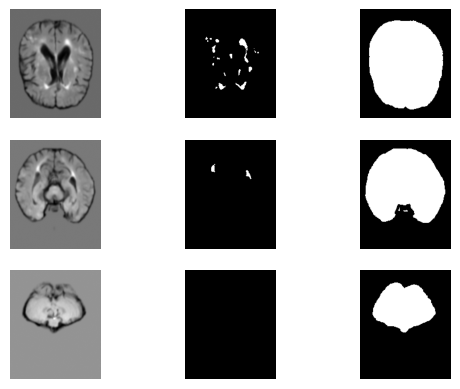

In [78]:
data = transformed_ds[0]

islices = [30, 45, 60]

for idx, islice in enumerate(islices):
    plt.subplot(3, 3, 1 + idx * 3)
    plt.imshow(data['FLAIR'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')
    plt.subplot(3, 3, 2 + idx * 3)
    plt.imshow(data['lbcWMH'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')
    plt.subplot(3, 3, 3 + idx * 3)
    plt.imshow(data['brainmask'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')

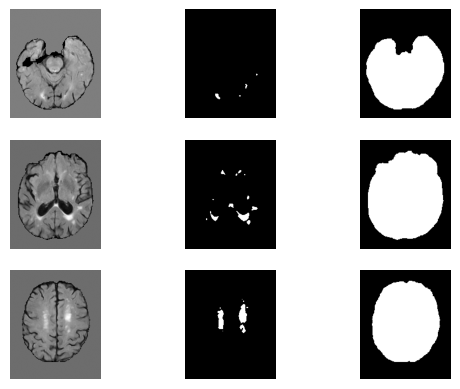

In [65]:
data = lbc_val[0]

islices = [30, 45, 60]

for idx, islice in enumerate(islices):
    plt.subplot(3, 3, 1 + idx * 3)
    plt.imshow(data['FLAIR'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')
    plt.subplot(3, 3, 2 + idx * 3)
    plt.imshow(data['lbcWMH'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')
    plt.subplot(3, 3, 3 + idx * 3)
    plt.imshow(data['brainmask'][0, islices[idx]], cmap='gray', origin='lower')
    plt.axis('off')

In [56]:
data.keys()

dict_keys(['FLAIR', 'lbcWMH', 'brainmask'])

In [34]:
lbc_val[0].keys()

dict_keys(['FLAIR', 'lbcWMH', 'brainmask'])